# Metadata analysis of the MAST dataset

Reference: https://mastapp.site/

### Objectives:

* How many shots in the M9 campaign?
* Find label for each shot that tells if the shot is good or not? (how many shot left?)
* For a given shot, find labels for each diagnostic that tells if its a wrong one or not?
* A variable is called efit and refers to the EFIT++ reconstruction. See if there are information about the meaning of the variables.

In [64]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import xarray as xr
import pathlib
import tqdm

plt.rcParams["font.family"] = "sans"
plt.rcParams["font.size"] = 8
sns.set_palette('muted')

#### 0. Visualization of the whole shots

In [2]:
URL = 'https://mastapp.site'

In [3]:
shots_df = pd.read_parquet(f'{URL}/parquet/level2/shots')
shots_df

,context,url,preshot_description,postshot_description,campaign,current_range,divertor_config,plasma_shape,commissioner,facility,...,cpf_vol_ipmax,cpf_vol_max,cpf_vol_truby,cpf_wmhd_ipmax,cpf_wmhd_max,cpf_wmhd_truby,cpf_zeff_ipmax,cpf_zeff_max,cpf_zeff_truby,cpf_zmag_efit
0,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",s3://mast/level2/shots/11766.zarr,\nRELOAD 10232 PLASMA CONDITIONING SHOT FROM M4\n,"\nGOOD PLASMA, RAN FINE. SL JOINT ALARMS RATHE...",M5,None,Conventional,None,None,MAST,...,8.088068,8.478948,NaN,9286.269388,14370.632,NaN,NaN,NaN,NaN,-0.011828
1,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",s3://mast/level2/shots/11767.zarr,\nREPEAT\n,\nOK BUT LOST VERTICAL CONTROL - FA2 JUST DIED...,M5,None,Conventional,None,None,MAST,...,7.707199,8.559942,NaN,7343.788162,11461.490,NaN,NaN,NaN,NaN,-0.007570
2,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",s3://mast/level2/shots/11768.zarr,\nSELECT ALL 4 FAS AND LOAD EFC SETTINGS FROM ...,\nOK. GOT FA4 BUT NOT FA3\n,M5,None,Conventional,None,None,MAST,...,8.300782,8.580827,NaN,10585.928086,12660.081,NaN,NaN,NaN,NaN,-0.011107
3,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",s3://mast/level2/shots/11769.zarr,"\nREPEAT, WITH TF RAISED TO 0.58.\n",\nSLIDING JOINT ALARMS A BIT LOWER. PLASMA OK.\n,M5,None,Conventional,None,None,MAST,...,8.112973,8.742647,NaN,8189.273726,12494.456,NaN,NaN,NaN,NaN,-0.008156
4,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",s3://mast/level2/shots/11771.zarr,\nRELOADED 11769 AND SET UP PLASMA CURRENT FEE...,\nGOOD PLASMA F/B CONTROL. SLIDING JOINT ALARM...,M5,None,Conventional,None,None,MAST,...,7.978917,8.760519,NaN,8206.258460,12345.816,NaN,NaN,NaN,NaN,-0.008726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11276,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",s3://mast/level2/shots/30467.zarr,\nRepeat with new neutron camera position.\ncH...,\nTwo times lower DD neutron rate than referen...,M9,700 kA,Conventional,Connected Double Null,None,MAST,...,9.029202,9.046394,NaN,49469.122469,52653.445,NaN,NaN,NaN,NaN,0.013202
11277,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",s3://mast/level2/shots/30468.zarr,\nRepeat with new neutron camera position.\ncH...,\nGood beam.\nGood repeat.\n,M9,700 kA,Conventional,Lower Single Null,None,MAST,...,9.102411,9.107017,NaN,48516.962675,49382.133,NaN,NaN,NaN,NaN,0.012445
11278,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",s3://mast/level2/shots/30469.zarr,\nRepeat with increased beam power (74 kV)\ncH...,\nGood shot. Modes present.\n,M9,700 kA,Conventional,Connected Double Null,None,MAST,...,8.988730,9.047923,NaN,47466.249616,49115.805,NaN,NaN,NaN,NaN,0.015299
11279,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",s3://mast/level2/shots/30470.zarr,\nRepeat last using hydrogen in outboard and c...,\nNo HF gas.\n,M9,700 kA,Conventional,None,None,MAST,...,9.687049,10.055509,NaN,17290.432865,22310.516,NaN,NaN,NaN,NaN,0.015164


In [4]:
columns = shots_df.columns
print(f'Number of columns: {len(columns)}\n')
for col in columns:
    print(f"{col.ljust(25)}: {shots_df[col].dtype}")

Number of columns: 290

context                  : object
url                      : object
preshot_description      : object
postshot_description     : object
campaign                 : object
current_range            : object
divertor_config          : object
plasma_shape             : object
commissioner             : object
facility                 : object
type                     : object
title                    : object
shot_id                  : int64
uuid                     : object
endpoint_url             : object
timestamp                : datetime64[ns]
reference_shot           : float64
scenario                 : float64
heating                  : object
pellets                  : object
rmp_coil                 : object
cpf_p03249               : object
cpf_p04673               : object
cpf_p04674               : object
cpf_p04675               : object
cpf_p04676               : object
cpf_p04677               : object
cpf_p04678               : object
cpf_p04679     

In [5]:
print(shots_df.loc[0, 'cpf_zmag_efit'])

-0.01182766


#### 1. M9 campaign selection

In [6]:
shots_df_m9 = pd.read_parquet(f'{URL}/parquet/level2/shots?filters=campaign$eq:M9')
shots_df_m9

,context,url,preshot_description,postshot_description,campaign,current_range,divertor_config,plasma_shape,commissioner,facility,...,cpf_vol_ipmax,cpf_vol_max,cpf_vol_truby,cpf_wmhd_ipmax,cpf_wmhd_max,cpf_wmhd_truby,cpf_zeff_ipmax,cpf_zeff_max,cpf_zeff_truby,cpf_zmag_efit
0,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",s3://mast/level2/shots/28752.zarr,\nChange ZREF to +1cm.\n,\n280ms shot.\n,M9,700 kA,Conventional,Connected Double Null,None,MAST,...,8.654442,8.727527,None,44755.881482,67405.750,None,None,None,None,0.032862
1,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",s3://mast/level2/shots/28647.zarr,\nRepeat after abort.\n,\nGood 400kA 330ms plasma shot.\n,M9,400 kA,Conventional,None,None,MAST,...,6.784744,9.231632,None,7209.400804,14854.986,None,None,None,None,-0.063345
2,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",s3://mast/level2/shots/28750.zarr,\nChange zref to -1 cm\n,\n470ms shot. 400ms SS NBI. Sawteeth from 250m...,M9,700 kA,Conventional,Connected Double Null,None,MAST,...,9.083099,9.108404,None,44471.072260,72576.510,None,None,None,None,0.004665
3,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",s3://mast/level2/shots/28631.zarr,"\nRepeat, with loop volts tweak and +-25kA P1P...",\nFirst plasma.\n,M9,400 kA,Conventional,None,None,MAST,...,5.389849,7.971025,None,1190.965664,3060.270,None,None,None,None,NaN
4,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",s3://mast/level2/shots/28632.zarr,"\nRepeat, with -ve P1PS current limit 45kA. Tw...",\nGood plasma shot.\n,M9,400 kA,Conventional,None,None,MAST,...,8.597655,8.830988,None,5577.911845,24692.621,None,None,None,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1096,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",s3://mast/level2/shots/30467.zarr,\nRepeat with new neutron camera position.\ncH...,\nTwo times lower DD neutron rate than referen...,M9,700 kA,Conventional,Connected Double Null,None,MAST,...,9.029202,9.046394,None,49469.122469,52653.445,None,None,None,None,0.013202
1097,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",s3://mast/level2/shots/30468.zarr,\nRepeat with new neutron camera position.\ncH...,\nGood beam.\nGood repeat.\n,M9,700 kA,Conventional,Lower Single Null,None,MAST,...,9.102411,9.107017,None,48516.962675,49382.133,None,None,None,None,0.012445
1098,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",s3://mast/level2/shots/30469.zarr,\nRepeat with increased beam power (74 kV)\ncH...,\nGood shot. Modes present.\n,M9,700 kA,Conventional,Connected Double Null,None,MAST,...,8.988730,9.047923,None,47466.249616,49115.805,None,None,None,None,0.015299
1099,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",s3://mast/level2/shots/30470.zarr,\nRepeat last using hydrogen in outboard and c...,\nNo HF gas.\n,M9,700 kA,Conventional,None,None,MAST,...,9.687049,10.055509,None,17290.432865,22310.516,None,None,None,None,0.015164


In [7]:
print(f"Number of shots in M9 campaign: {len(shots_df_m9)}")

Number of shots in M9 campaign: 1101


Find the list of the M9 campaign shot_id

In [8]:
m9_shot_ids = shots_df_m9['shot_id'].tolist()

print(f"Number of shot IDs in M9 campaign: {len(m9_shot_ids)}")
print("M9 campaign shot_id:", m9_shot_ids[:5])

Number of shot IDs in M9 campaign: 1101
M9 campaign shot_id: [28752, 28647, 28750, 28631, 28632]


*Conclusion :*

*The number of shots during the M9 campaign is 1101.*

*That represents 8.89 % of the 11281 shots over all campaign.*


#### 2. Find labels for each shot

Interesting columns:
* `cpf_abort`: interupted shot if 1
* `cpf_useful`: good for analysis if 1

In [9]:
# Sélectionner les colonnes spécifiques
abort_values = shots_df_m9['cpf_abort']
useful_values = shots_df_m9['cpf_useful']

# Afficher les 5 premières valeurs (exemple)
print("Valeurs de cpf_abort :\n", abort_values.describe())
print("\nValeurs de cpf_useful :\n", useful_values.describe())

Valeurs de cpf_abort :
 count    2.0
mean     1.0
std      0.0
min      1.0
25%      1.0
50%      1.0
75%      1.0
max      1.0
Name: cpf_abort, dtype: float64

Valeurs de cpf_useful :
 count    755.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: cpf_useful, dtype: float64


In [10]:
good_shots = shots_df_m9.loc[(shots_df_m9['cpf_useful'] == 1) & (shots_df_m9['cpf_abort'] != 1)]
print(f"Number of good shots in M9 campaign: {len(good_shots)}")

Number of good shots in M9 campaign: 755


In [11]:
shots_df_m9['shot_label'] = (shots_df_m9['cpf_useful'] == 1).astype(int)
shots_df_m9[['shot_id','cpf_useful', 'cpf_abort', 'shot_label']]

,shot_id,cpf_useful,cpf_abort,shot_label
0,28752,1.0,NaN,1
1,28647,NaN,NaN,0
2,28750,1.0,NaN,1
3,28631,NaN,NaN,0
4,28632,NaN,NaN,0
...,...,...,...,...
1096,30467,1.0,NaN,1
1097,30468,1.0,NaN,1
1098,30469,1.0,NaN,1
1099,30470,NaN,NaN,0


Find the list of good shot_id and the list of bad shot_id.

In [12]:
good_shot_ids = shots_df_m9.loc[shots_df_m9['shot_label'] == 1, 'shot_id'].tolist()
bad_shot_ids = shots_df_m9.loc[shots_df_m9['shot_label'] == 0, 'shot_id'].tolist()

print(f"Number of good shot IDs: {len(good_shot_ids)}")
print("Good shot IDs:", good_shot_ids[:25])

print("\n")

print(f"Number of bad shot IDs: {len(bad_shot_ids)}")
print("Bad shot IDs:", bad_shot_ids[:5])

Number of good shot IDs: 755
Good shot IDs: [28752, 28750, 28655, 28656, 28657, 28744, 28751, 28747, 28748, 28749, 28755, 28757, 28758, 28763, 28801, 28764, 28765, 28766, 28767, 28768, 28769, 28770, 28771, 28772, 28773]


Number of bad shot IDs: 346
Bad shot IDs: [28647, 28631, 28632, 28652, 28653]


#### 3. Find label for each disgnostics (M9 campaign + magnetics)

Finding a label per diagnostic is quite more difficult.

1. We will first try to see if there are labels in the existant dataset.
2. If not, we will implement unsuvervised technics to label the dataset.

In [13]:
# Shot_id number for example
sh_id = 28752
#sh_id = 15585
grp = 'magnetics'

In [14]:
data = xr.open_zarr(
    f"https://s3.echo.stfc.ac.uk/mast/level2/shots/{sh_id}.zarr",
    group=grp,
)
mag_var = data.data_vars
mag_var

Data variables:
    b_field_pol_probe_ccbv_field      (b_field_pol_probe_ccbv_channel, time) float64 741kB ...
    b_field_pol_probe_obr_field       (b_field_pol_probe_obr_channel, time) float64 334kB ...
    b_field_pol_probe_obv_field       (b_field_pol_probe_obv_channel, time) float64 334kB ...
    b_field_tor_probe_saddle_field    (b_field_tor_probe_saddle_field_channel, time_saddle) float64 2MB ...
    b_field_tor_probe_saddle_voltage  (b_field_tor_probe_saddle_voltage_channel, time_saddle) float64 2MB ...
    flux_loop_flux                    (flux_loop_channel, time) float64 278kB ...
    ip                                (time) float64 19kB ...

In [15]:
for var in mag_var:
    print(f"{var.ljust(35)}: {mag_var[var].attrs}")

b_field_pol_probe_ccbv_field       : {'description': 'Centre column Bv array', 'imas': 'magnetics.b_field_pol_probe[:].field.data', 'label': 'CCBV01', 'name': 'b_field_pol_probe_ccbv_field', 'uda_name': 'AMB_CCBV01', 'units': 'T'}
b_field_pol_probe_obr_field        : {'description': 'Outer Br array', 'imas': 'magnetics.b_field_pol_probe[:].field.data', 'label': 'OBR01', 'name': 'b_field_pol_probe_obr_field', 'uda_name': 'AMB_OBR01', 'units': 'T'}
b_field_pol_probe_obv_field        : {'description': 'Outer Bv array', 'imas': 'magnetics.b_field_pol_probe[:].field.data', 'name': 'b_field_pol_probe_obv_field', 'units': 'T'}
b_field_tor_probe_saddle_field     : {'description': '', 'imas': 'magnetics.b_field_tor_probe[:].field.data', 'label': 'mT', 'name': 'b_field_tor_probe_saddle_field', 'uda_name': 'ASM_SAD/M01', 'units': 'T'}
b_field_tor_probe_saddle_voltage   : {'description': '', 'imas': 'magnetics.b_field_tor_probe[:].voltage.data', 'label': 'V', 'name': 'b_field_tor_probe_saddle_volt

In [16]:
data['ip']['time'].values

array([-0.10280025, -0.10260025, -0.10240025, ...,  0.35979975,
        0.35999975,  0.36019975], shape=(2316,))

In [17]:
signals_df = pd.read_parquet(f"{URL}/parquet/level2/signals?shot_id={sh_id}")
signals_df.head(5)

,context,shape,provenance,description,dimensions,quality,type,title,uuid,name,version,rank,url,endpoint_url,source,units,imas,shot_id
0,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",[2316],None,,[time],Not Checked,dcat:Dataset,Signal Dataset,e394530f-e608-5d90-93da-1851ec2cd082,ip,0,1,s3://mast/level2/shots/28752.zarr,https://s3.echo.stfc.ac.uk,magnetics,A,magnetics,28752
1,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",[93],None,,[time],Not Checked,dcat:Dataset,Signal Dataset,1ef217e3-12b0-5523-bfbf-f466db059e31,beta_normal,0,1,s3://mast/level2/shots/28752.zarr,https://s3.echo.stfc.ac.uk,equilibrium,,equilibrium,28752
2,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",[93],None,,[time],Not Checked,dcat:Dataset,Signal Dataset,294c6905-fba4-5682-b8e0-047000ee5098,beta_pol,0,1,s3://mast/level2/shots/28752.zarr,https://s3.echo.stfc.ac.uk,equilibrium,,equilibrium,28752
3,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",[93],None,,[time],Not Checked,dcat:Dataset,Signal Dataset,ed36483e-c8b5-56e1-9b92-67c9acd13e12,beta_tor,0,1,s3://mast/level2/shots/28752.zarr,https://s3.echo.stfc.ac.uk,equilibrium,,equilibrium,28752
4,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",[93],None,,[time],Not Checked,dcat:Dataset,Signal Dataset,12feafef-7d0f-59a5-a5a7-226739e9008c,bphi_rmag,0,1,s3://mast/level2/shots/28752.zarr,https://s3.echo.stfc.ac.uk,equilibrium,,equilibrium,28752


In [18]:
signals_df.loc[4]

context         {'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...
shape                                                        [93]
provenance                                                   None
description                                                      
dimensions                                                 [time]
quality                                               Not Checked
type                                                 dcat:Dataset
title                                              Signal Dataset
uuid                         12feafef-7d0f-59a5-a5a7-226739e9008c
name                                                    bphi_rmag
version                                                         0
rank                                                            1
url                             s3://mast/level2/shots/28752.zarr
endpoint_url                           https://s3.echo.stfc.ac.uk
source                                                equilibrium
units     

In [19]:
signals_df.loc[signals_df['imas']=='magnetics'].head(5)

,context,shape,provenance,description,dimensions,quality,type,title,uuid,name,version,rank,url,endpoint_url,source,units,imas,shot_id
0,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...",[2316],None,,[time],Not Checked,dcat:Dataset,Signal Dataset,e394530f-e608-5d90-93da-1851ec2cd082,ip,0,1,s3://mast/level2/shots/28752.zarr,https://s3.echo.stfc.ac.uk,magnetics,A,magnetics,28752
35,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...","[40, 2316]",None,,"[b_field_pol_probe_ccbv_channel, time]",Not Checked,dcat:Dataset,Signal Dataset,586ebaa8-2901-5ccb-a88f-c91b7fa469af,b_field_pol_probe_ccbv_field,0,2,s3://mast/level2/shots/28752.zarr,https://s3.echo.stfc.ac.uk,magnetics,A,magnetics,28752
36,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...","[18, 2316]",None,,"[b_field_pol_probe_obr_channel, time]",Not Checked,dcat:Dataset,Signal Dataset,4db8b61d-8d92-5f24-885e-114be1ad0775,b_field_pol_probe_obr_field,0,2,s3://mast/level2/shots/28752.zarr,https://s3.echo.stfc.ac.uk,magnetics,A,magnetics,28752
37,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...","[18, 2316]",None,,"[b_field_pol_probe_obv_channel, time]",Not Checked,dcat:Dataset,Signal Dataset,63fce13c-2ed9-5378-aa29-03c5a457f4a1,b_field_pol_probe_obv_field,0,2,s3://mast/level2/shots/28752.zarr,https://s3.echo.stfc.ac.uk,magnetics,A,magnetics,28752
38,"{'dcat': 'http://www.w3.org/ns/dcat#', 'dct': ...","[12, 23160]",None,,"[b_field_tor_probe_saddle_field_channel, time_...",Not Checked,dcat:Dataset,Signal Dataset,d9a3b4c0-06be-58fc-95b8-9891253e7d12,b_field_tor_probe_saddle_field,0,2,s3://mast/level2/shots/28752.zarr,https://s3.echo.stfc.ac.uk,magnetics,A,magnetics,28752


In [20]:
shot_data = requests.get(f'https://mastapp.site/json/shots/{sh_id}').json()
for key, value in shot_data.items():
    if isinstance(value, list):
        print(f"{key.ljust(30)}: {len(value)} items")
    else:
        print(f"{key.ljust(30)}: {value}")

@context                      : {'dct': 'http://purl.org/dc/terms/', 'dqv': 'http://www.w3.org/ns/dqv#', 'url': 'schema:url', 'dcat': 'http://www.w3.org/ns/dcat#', 'foaf': 'http://xmlns.com/foaf/0.1/', 'uuid': 'dct:identifier', 'title': 'dct:title', 'schema': 'https://schema.org', 'timestamp': 'dct:date', 'sdmx-measure': 'http://purl.org/linked-data/sdmx/2009/measure#'}
@type                         : dcat:Dataset
title                         : Shot Dataset
shot_id                       : 28752
uuid                          : 2bd7255e-9f9e-59ba-8968-6ece568e5755
url                           : s3://mast/level1/shots/28752.zarr
endpoint_url                  : https://s3.echo.stfc.ac.uk
timestamp                     : 2013-05-20T13:30:00
preshot_description           : 
Change ZREF to +1cm.

postshot_description          : 
280ms shot.

campaign                      : M9
reference_shot                : 28751
scenario                      : 3
heating                       : Ohmic
pellets

In [22]:
endpoint, url = shot_data["endpoint_url"], shot_data["url"]
shot_url = url.replace("s3:/", endpoint)
print(f"Shot URL: {shot_url}")

Shot URL: https://s3.echo.stfc.ac.uk/mast/level1/shots/15585.zarr


*Conclusion :*

*Nothing here seems to be a good label for each diagnostic.*

*Update: After speaking with Samuel Jackson, there are in fact no label available for each diagnostics. But also, the shots' labels are kind of subjective and hand-crafted.*

#### 4. EFIT++ information meaning

In [48]:
sh_id = 28752
sh_id = 15585
sh_id = 26320

grp = 'equilibrium'

In [49]:
data_eq = xr.open_zarr(
    f"https://s3.echo.stfc.ac.uk/mast/level2/shots/{sh_id}.zarr",
    group=grp,
)
eq_var = data_eq.data_vars
eq_var

Data variables:
    beta_normal          (time) float64 2kB ...
    beta_pol             (time) float64 2kB ...
    beta_tor             (time) float64 2kB ...
    bphi_rmag            (time) float64 2kB ...
    bvac_rmag            (time) float64 2kB ...
    da_rating            (time) float64 2kB ...
    elongation           (time) float64 2kB ...
    elongation_axis      (time) float64 2kB ...
    ip_rating            (time) float64 2kB ...
    j_tor                (time, z, major_radius) float64 9MB ...
    lcfs_r               (time, n_boundary_coords) float64 292kB ...
    lcfs_z               (time, n_boundary_coords) float64 292kB ...
    li                   (time) float64 2kB ...
    magnetic_axis_r      (time) float64 2kB ...
    magnetic_axis_z      (time) float64 2kB ...
    minor_radius         (time) float64 2kB ...
    psi                  (time, z, major_radius) float64 9MB ...
    q                    (time, profile_r) float64 131kB ...
    q100                 (time)

In [50]:
eq_coord = data_eq.coords
eq_coord

Coordinates:
  * major_radius       (major_radius) float64 520B 0.06 0.09 0.12 ... 1.95 1.98
  * n_boundary_coords  (n_boundary_coords) float32 580B 0.0 1.0 ... 143.0 144.0
  * n_x_points         (n_x_points) <U16 256B 'EFM_XPOINT1_R(C)' ... 'EFM_XPO...
  * profile_r          (profile_r) float32 260B 0.0 0.01562 ... 0.9844 1.0
  * time               (time) float64 2kB -0.4608 -0.4558 ... 0.7892 0.7942
  * z                  (z) float32 260B -2.0 -1.938 -1.875 ... 1.875 1.938 2.0

In [51]:
data_eq["psi"].attrs

{'description': '',
 'imas': 'equilibrium.time_slice[:].profiles_2d[:].psi',
 'label': 'psi(r,z)',
 'name': 'psi',
 'uda_name': 'EFM_PSI(R,Z)',
 'units': 'Wb / rad'}

In [57]:
data_eq["psi"].values[100]

array([[0.00038638, 0.00086685, 0.00153275, ..., 0.00330089, 0.00301806,
        0.00275437],
       [0.00046341, 0.0010403 , 0.00184113, ..., 0.00288405, 0.00259976,
        0.00233654],
       [0.0005515 , 0.0012376 , 0.00218985, ..., 0.00234794, 0.00207251,
        0.00181878],
       ...,
       [0.00058527, 0.00131555, 0.00233335, ..., 0.00662314, 0.00618463,
        0.00578194],
       [0.00049538, 0.00111266, 0.00197022, ..., 0.0072327 , 0.00677648,
        0.0063575 ],
       [0.00041507, 0.00093144, 0.00164746, ..., 0.00762706, 0.00717949,
        0.00676557]], shape=(65, 65))

### 5. Is `shot_id` crescent with the `timestamp` ?

In [46]:
sh_id = 28752
sh_id = 15585

In [47]:
shot_timestamp = requests.get(f'https://mastapp.site/json/shots/{sh_id}').json()["timestamp"]
shot_timestamp

'2006-06-08T12:57:00'

In [40]:
URL = 'https://mastapp.site'
shots_order = pd.read_parquet(f'{URL}/parquet/level2/shots') 

In [41]:
columns = shots_order.columns 
print(f'Number of columns: {len(columns)}\n')
for col in columns:
    print(f"{col.ljust(25)}: {shots_order[col].dtype}")

Number of columns: 290

context                  : object
url                      : object
preshot_description      : object
postshot_description     : object
campaign                 : object
current_range            : object
divertor_config          : object
plasma_shape             : object
commissioner             : object
facility                 : object
type                     : object
title                    : object
shot_id                  : int64
uuid                     : object
endpoint_url             : object
timestamp                : datetime64[ns]
reference_shot           : float64
scenario                 : float64
heating                  : object
pellets                  : object
rmp_coil                 : object
cpf_p03249               : object
cpf_p04673               : object
cpf_p04674               : object
cpf_p04675               : object
cpf_p04676               : object
cpf_p04677               : object
cpf_p04678               : object
cpf_p04679     

In [42]:
sorted_order = shots_order.sort_values("timestamp")

In [43]:
is_sorted = sorted_order["shot_id"].is_monotonic_increasing
print(f"Shot IDs are sorted by timestamp: {is_sorted}")

Shot IDs are sorted by timestamp: False


In [44]:
if not is_sorted:
    diffs = sorted_order["shot_id"].diff().fillna(1)
    non_increasing = sorted_order[diffs <= 0]
    print("Number of non-increasing shot_ids: ", len(non_increasing), "\n")
    print("Non-increasing shot_ids:")
    non_increasing_list = non_increasing[["timestamp", "shot_id"]].values.tolist()
    for ts, shot_id in non_increasing_list:
        print(f"Timestamp: {ts}, Shot ID: {shot_id}")

    file_path = "src/magnetics_diagnostic_analysis/results"
    suffix = ""
    path = pathlib.Path().absolute().parent.parent.parent / file_path / f"non_increasing_shot_id{suffix}.csv"
    non_increasing_list = pd.Series(non_increasing_list)
    non_increasing_list.to_csv(path, index=False)

Number of non-increasing shot_ids:  21 

Non-increasing shot_ids:
Timestamp: 2006-06-13 13:08:00, Shot ID: 15632
Timestamp: 2006-07-25 09:15:00, Shot ID: 15951
Timestamp: 2006-08-22 09:20:00, Shot ID: 16310
Timestamp: 2007-01-18 10:29:00, Shot ID: 16847
Timestamp: 2007-07-18 08:51:00, Shot ID: 18882
Timestamp: 2008-06-25 09:49:00, Shot ID: 19536
Timestamp: 2008-07-10 09:12:00, Shot ID: 19700
Timestamp: 2008-09-11 10:22:00, Shot ID: 20294
Timestamp: 2008-10-28 13:52:00, Shot ID: 20722
Timestamp: 2008-11-13 09:55:00, Shot ID: 20909
Timestamp: 2008-11-26 17:54:00, Shot ID: 20972
Timestamp: 2009-02-25 10:50:00, Shot ID: 21433
Timestamp: 2009-05-19 11:07:00, Shot ID: 22376
Timestamp: 2009-10-13 09:17:00, Shot ID: 23336
Timestamp: 2009-12-17 00:00:00, Shot ID: 23943
Timestamp: 2009-12-17 13:09:00, Shot ID: 23927
Timestamp: 2010-01-28 09:44:00, Shot ID: 24194
Timestamp: 2011-04-12 09:13:00, Shot ID: 25732
Timestamp: 2011-06-24 09:36:00, Shot ID: 26397
Timestamp: 2011-07-10 23:00:00, Shot ID: 

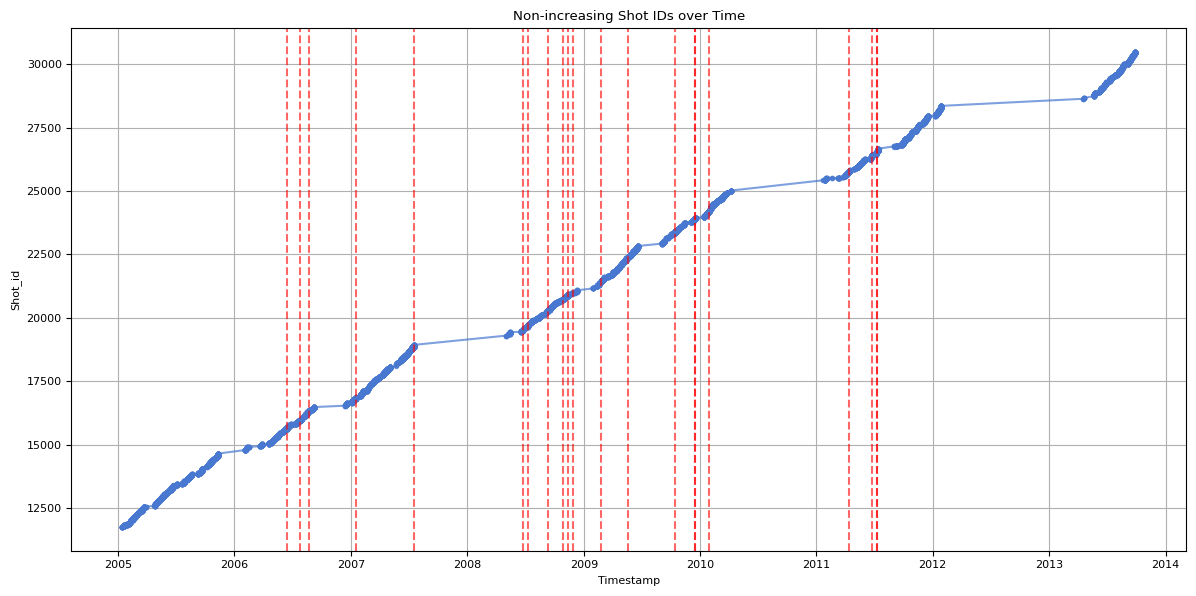

In [45]:
plt.figure(figsize=(12, 6))
plt.plot(sorted_order["timestamp"], sorted_order["shot_id"], marker='.', linestyle='-', alpha=0.7)
plt.xlabel("Timestamp")
plt.ylabel("Shot_id")
plt.title("Non-increasing Shot IDs over Time")
plt.grid(True)

# Red vertical lines for non-increasing shot_ids
for ts in non_increasing["timestamp"]:
    plt.axvline(x=ts, color='red', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

*Conclusion :*

*The number of non-increasing shot_id through time are negligeable in comparison with the number of shots.*

### 6. Analysis of NaN apparition through time

In [70]:
def to_dask(shot: int, group: str, level: int = 2) -> xr.Dataset:
    """
    Return a Dataset from the MAST Zarr store.

    Parameters
    shot: Shot ID to retrieve data for.
    group: Diagnostic group to retrieve data from.
    level: Data level to retrieve (default is 2).
    """
    return xr.open_zarr(
        f"https://s3.echo.stfc.ac.uk/mast/level{level}/shots/{shot}.zarr",
        group=group,
    )

In [79]:
def build_variable_vs_timestamp(
    shots: list[int],
    group: str,
    variable: str,
    verbose: bool = False
) -> xr.Dataset:
    """
    Concat data from a variable across multiple shots, aligned in absolute time based on the start timestamp of each shot.
    
    Parameters
    shots: list of int
        List of shot IDs to be processed.
    group: str
        Diagnostic group to which the variable belongs (e.g., “magnetics,” “summary,” etc.).
    variable: str
        Name of the variable to be retrieved.
    verbose: bool
        Displays messages for debugging or tracking.

    Returns
    xr.Dataset
        Dataset containing the variable concatenated across all shots, based on the actual timestamp.
    """
    all_data = []

    for shot_id in tqdm.tqdm(shots, desc="Loading shots", total=len(shots)):
        try:
            # Load data
            ds = to_dask(shot_id, group)
            if variable not in ds:
                if verbose:
                    print(f"Variable {variable} not in group {group} for shot {shot_id}")
                continue
            da = ds[variable]

            # Get timestamp of shot begining
            meta = requests.get(f"https://mastapp.site/json/shots/{shot_id}").json()
            t0 = pd.to_datetime(meta["timestamp"]).timestamp()  # UNIX timestamp (secondes))

            time_dim = next((dim for dim in da.dims if dim.startswith("time")), None)
            if time_dim is None:
                if verbose:
                    print(f"Aucune dimension temporelle pour {variable} dans shot {shot_id}")
                continue

            # Absolute time (secondes since UNIX)
            relative_time = ds[time_dim].values.astype(np.float64)  # secondes
            global_time = pd.to_datetime(t0 + relative_time, unit='s')  # Convert to datetime

            # New array with global time
            coords = {"time": global_time}
            dims = ("time",)
            if da.ndim == 2:
                chan_dim = [dim for dim in da.dims if dim != time_dim][0]
                coords[chan_dim] = ds[chan_dim]
                dims = ("time", chan_dim)

            da_new = xr.DataArray(
                da.values,
                dims=dims,
                coords=coords,
                attrs=da.attrs
            )

            all_data.append(da_new)

        except Exception as e:
            if verbose:
                print(f"Erreur avec le shot {shot_id}: {e}")
            continue

    result = xr.concat(all_data, dim="time").sortby("time")

    return xr.Dataset({variable: result})

In [80]:
URL = 'https://mastapp.site'
shots_disappearance = pd.read_parquet(f'{URL}/parquet/level2/shots')
sorted_disappearance = shots_disappearance.sort_values("timestamp")
shots = sorted_disappearance['shot_id'].tolist()
print("Number of shots: ", len(shots))

Number of shots:  11281


In [81]:
group = 'magnetics'
variable = 'ip'

variable_vs_timestamp = build_variable_vs_timestamp(
    shots=shots[:100], 
    group=group, 
    variable=variable, 
    verbose=True)

Loading shots: 100%|██████████| 100/100 [04:07<00:00,  2.47s/it]


In [82]:
variable_vs_timestamp

<xarray.Dataset> Size: 4MB
Dimensions:  (time: 238745)
Coordinates:
  * time     (time) datetime64[ns] 2MB 2005-01-13T12:01:59.932800055 ... 2005...
Data variables:
    ip       (time) float64 2MB 5.039e+03 5.184e+03 ... 3.168e+03 3.168e+03

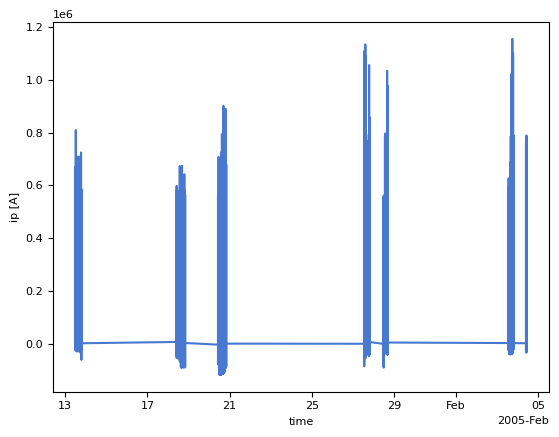

In [83]:
variable_vs_timestamp[variable].plot(x="time")

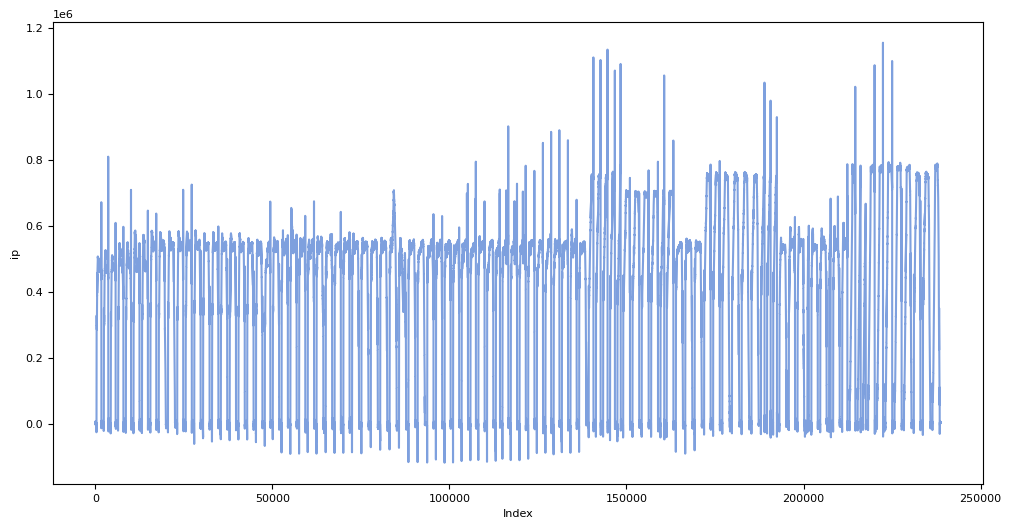

In [84]:
var_plot = variable_vs_timestamp[variable]
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(var_plot.values, alpha=0.7)
ax.set_xlabel("Index")
ax.set_ylabel(variable)
plt.show()

### 7. What are the `cpf_*` variables ?

In [ ]:
shots_df = pd.read_parquet(f'{URL}/parquet/level2/shots')

In [62]:
print(type(shots_df["cpf_p03249"]))
print("\n")
print(shots_df["cpf_p03249"])

<class 'pandas.core.series.Series'>


0        None
1        None
2        None
3        None
4        None
         ... 
11276    None
11277    None
11278    None
11279    None
11280    None
Name: cpf_p03249, Length: 11281, dtype: object


In [63]:
print(type(shots_df["cpf_p04673"]))
print("\n")
print(shots_df["cpf_p04673"])

<class 'pandas.core.series.Series'>


0        None
1        None
2        None
3        None
4        None
         ... 
11276    None
11277    None
11278    None
11279    None
11280    None
Name: cpf_p04673, Length: 11281, dtype: object


### 8. --------